This notebook uses the data produced by `3_fever_processing_for_textual_entailment` to train and evaluate a BERT model for textual entailment. 

Different from `4_Using_BERT_on_FEVER_with_Trainer_3_Classes_DATASET_V2`, we take a slightly different training approach by:
- Experimenting with some different parameters
    - This generates new models that we think might perform a bit better
- And employing hyperparameter search as well
    - Same as above

In [1]:
import numpy as np
import random
import torch
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit as GSS
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import transformers

from seaborn import displot, boxplot
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'bert-base-uncased'
BATCH_SIZE = 16
NUM_WORKERS = 2 #was 4 on Rosalind
MAX_LEN = 128 # was much bigger (300-400) on the other versions but let's compromise on complexity here

In [3]:
df_train = read_csv('./data/support_data_v2/train_support_from_bert.csv', encoding='UTF-8')
df_dev_test = read_csv('./data/support_data_v2/dev_support_from_bert.csv', encoding='UTF-8')
#df_test = read_csv('./data/support_data_v2/test_support_from_bert.csv', encoding='UTF-8')
df_train.columns

Index(['id', 'evidence', 'claim', 'label', 'evidence_page', 'evidence_line',
       'evidence_text', 'evidence_score'],
      dtype='object')

In [4]:
LABELS = ['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO']
def label_to_numeric(row):
    if 'label' in row:
        return LABELS.index(row['label'])
    return -1

df_train['label_numeric'] = df_train.apply(label_to_numeric, axis=1)
df_dev_test['label_numeric'] = df_dev_test.apply(label_to_numeric, axis=1)

In [5]:
columns_to_keep = ['id','claim','evidence_text','label_numeric']
df_train = df_train[columns_to_keep]
df_dev_test = df_dev_test[columns_to_keep]

SPLIT_METHOD = 'GSS'
if SPLIT_METHOD == 'GSS':
    gss = GSS(n_splits=1, train_size=.5, random_state=42)
    dev_ix, test_ix = next(gss.split(df_dev_test, groups=df_dev_test.id))
    df_test = df_dev_test.iloc[test_ix]
    df_dev = df_dev_test.iloc[dev_ix]
else:
    df_test, df_dev = train_test_split(df_dev_test, test_size=.5)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_dev = df_dev.reset_index(drop=True)
df_train.shape, df_test.shape, df_dev.shape

((173960, 4), (12673, 4), (12721, 4))

In [6]:
assert not np.any([(i in df_test.id.unique()) for i in df_dev.id.unique()])
assert not np.any([(i in df_dev.id.unique()) for i in df_test.id.unique()])

In [7]:
df_train.label_numeric.value_counts()

0    81583
2    59114
1    33263
Name: label_numeric, dtype: int64

In [8]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, fast=True)

In [9]:
check_lengths = False

if check_lengths:
    # This helps see what a good max length would be
    def get_tokenized_len(row):
        tokens = tokenizer.encode(row['claim'], row['evidence_text'], max_length=512, truncation='only_second')
        return len(tokens)

    for df in [df_train, df_test, df_dev]:
        df['tokenized_len'] = df.apply(get_tokenized_len, axis=1)

    tokenized_lens = df_train['tokenized_len'].tolist() +\
        df_test['tokenized_len'].tolist() +\
        df_dev['tokenized_len'].tolist()

    boxplot(x=tokenized_lens)
    plt.xlim([0, 512]);
    plt.xlabel('Token count');

    print(np.percentile(tokenized_lens, 99))
    # 113.0

In [10]:
class FEVERDataset(Dataset):
    def __init__(self, claims, sentences, labels, tokenizer, max_len):
        self.claims=claims
        self.sentences=sentences
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
        
    def __len__(self):
        return(len(self.claims))
    
    def __getitem__(self, idx):
        claim = self.claims[idx]
        sentence = self.sentences[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            claim,
            sentence,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        ).to(DEVICE)
        
        return {
            'claim': claim,
            'sentence': sentence,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long).to(DEVICE)
        }
    
def to_data_loader(df, tokenizer, max_len, batch_size, num_workers):
    dataset = FEVERDataset(
        claims = df.claim,
        sentences = df.evidence_text,
        labels = df.label_numeric,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return dataset, DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    
train_dataset, train_dataloader = to_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE, NUM_WORKERS)
test_dataset, test_dataloader = to_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE, NUM_WORKERS)
dev_dataset, dev_dataloader = to_data_loader(df_dev, tokenizer, MAX_LEN, BATCH_SIZE, NUM_WORKERS)

In [11]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [12]:
import gc
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Mon Mar 28 12:50:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:D8:00.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |     12MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Training

In [ ]:
SEED = 42
NUM_EPOCHS = 2

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

train_batch_size = 32 # 32 on Rosalind worked, but on Gravity we had to scale down
n_training_steps_per_epoch = np.ceil(len(train_dataset)/train_batch_size)

training_args = TrainingArguments(
    output_dir='./run/7_Using_BERT_on_FEVER_with_Trainer_3_Classes_DATASET_V2/',
    num_train_epochs=NUM_EPOCHS, #past version had 3, but 2 really usually is enough
    evaluation_strategy="steps",
    save_strategy="steps",
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=32, #past version had 64, perhaps this lets us have a better evaluation?
    learning_rate=2e-05, #The use used in the past version was 5e-5 (default).
    warmup_ratio=0.1,#06358,#0.01532848953 was used in the past version (500 / 32619 total steps)
    weight_decay=0.039676,
    seed=SEED,
    eval_steps=int(n_training_steps_per_epoch//(5*NUM_EPOCHS)),
    save_steps=int(n_training_steps_per_epoch//(5*NUM_EPOCHS)),
    save_total_limit=1,
    dataloader_pin_memory=False,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = 3).to(DEVICE)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics      # metrics to be computed
)

trainer.train()

In [ ]:
trainer.evaluate(eval_dataset = test_dataset, metric_key_prefix='test')

BEST SO FAR (ALL SEEDS = 42):
```
{
    'test_loss': 0.6015421152114868,
    'test_accuracy': 0.7665114811015545,
    'test_f1': 0.7684305227347576,
    'test_precision': 0.7663349147229986,
    'test_recall': 0.7763667260545638,
    'test_runtime': 50.8461,
    'test_samples_per_second': 249.242,
    'epoch': 2.0,
    'eval_mem_cpu_alloc_delta': 310133,
    'eval_mem_gpu_alloc_delta': 0,
    'eval_mem_cpu_peaked_delta': 630416,
    'eval_mem_gpu_peaked_delta': 138833408
}
```
WITH PARAMS:
```
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

train_batch_size = 32
n_training_steps_per_epoch = np.ceil(len(train_dataset)/train_batch_size)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    evaluation_strategy="steps",
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=32,
    learning_rate=1.7272998688284028e-05,
    warmup_ratio=0.1,
    weight_decay=0.01,
    seed=SEED,
    eval_steps=int(n_training_steps_per_epoch//10),
    save_total_limit=1, 
    dataloader_pin_memory=False,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)
```

In [ ]:
trainer.save_model('./models/BERT_FEVER_v3_model')
tokenizer.save_pretrained('models/BERT_FEVER_v3_tok')

## Loading the model again for sanity checking

In [ ]:
model2 = BertForSequenceClassification.from_pretrained('./models/BERT_FEVER_v3_model').to(DEVICE)
tokenizer2 = BertTokenizer.from_pretrained('models/BERT_FEVER_v3_tok')

In [ ]:
trainer2 = Trainer(
    model=model2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics      # metrics to be computed
)

trainer2.evaluate(eval_dataset = test_dataset, metric_key_prefix='test')

## Hyper-parameter fine-tuning

In [13]:
import ray
# Transformers 4.4.0 works, but updating breaks ray
from ray import tune
from ray.tune import JupyterNotebookReporter 
from ray.tune.examples.pbt_transformers.utils import download_data, \
    build_compute_metrics_fn
from ray.tune.schedulers import AsyncHyperBandScheduler, FIFOScheduler, PopulationBasedTraining

RAY_RESULTS_PATH = '/scratch/group_simperl/ray_hyperparameter/'

%matplotlib notebook

import transformers

transformers.logging.set_verbosity_error()

ray.shutdown()
ray.init(num_gpus=2, num_cpus=32)#, local_mode=True)

{'node_ip_address': '172.20.18.8',
 'raylet_ip_address': '172.20.18.8',
 'redis_address': '172.20.18.8:6379',
 'object_store_address': '/tmp/ray/session_2022-02-23_16-41-56_571000_5688/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-02-23_16-41-56_571000_5688/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-02-23_16-41-56_571000_5688',
 'metrics_export_port': 59129,
 'gcs_address': '172.20.18.8:34276',
 'node_id': 'fd221d06df6eedbf7649a30b5eea321f2f3699a70b39a064b4c429fb'}

In [14]:
import gc
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

E0223 16:42:14.438540300    6907 ev_epollex_linux.cc:515]    Error shutting down fd 85. errno: 9
Wed Feb 23 16:42:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3070    On   | 00000000:5E:00.0 Off |                  N/A |
| 30%   28C    P8    18W / 220W |      3MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+---------------

In [ ]:
SEED = 42

def model_init():
    #transformers.logging.set_verbosity_error()
    #gc.collect()
    torch.cuda.empty_cache()
    random.seed(SEED)
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    return BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = 3).to(DEVICE)

train_batch_size = 16
testing_hyper = False
n_training_steps_per_epoch = np.ceil(len(train_dataset)/train_batch_size)

training_args = TrainingArguments(
    output_dir = RAY_RESULTS_PATH + '7_Using_BERT_on_FEVER_with_Trainer_3_Classes_DATASET_V2_HYPER/',
    num_train_epochs=2,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=int(n_training_steps_per_epoch//10),
    save_steps=int(n_training_steps_per_epoch//10),
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints. 
    dataloader_pin_memory=False,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    do_eval=True,
    disable_tqdm = True,
    max_steps = 1 if testing_hyper else -1,
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics      # metrics to be computed
)

tune_config = {
    "per_device_eval_batch_size": 32,
    "per_device_train_batch_size": tune.grid_search([8, 16]),
    "learning_rate": tune.uniform(1e-5, 5e-5),
    "weight_decay": 0.01,
    "num_train_epochs": 2,#tune.choice([2, 3, 4])
    "warmup_ratio": 0.1,#tune.loguniform(1e-4, 10),#0.1,
    "eval_steps" : tune.sample_from(lambda spec: int(len(train_dataset)/spec.config.per_device_train_batch_size/20)),
    "save_steps" : tune.sample_from(lambda spec: int(len(train_dataset)/spec.config.per_device_train_batch_size/20)),
    "seed": SEED,
}

schedulerPBT = PopulationBasedTraining(
    time_attr="training_iteration",
    metric="eval_f1",
    mode="max",
    perturbation_interval=2,
    hyperparam_mutations={
        "weight_decay": tune.loguniform(1e-3, 1e-1),
        "learning_rate": tune.loguniform(1e-6, 1e-4),
        "per_device_train_batch_size": tune.choice([4, 8, 16]),
    })

#schedulerASHA = AsyncHyperBandScheduler(
#        time_attr="training_iteration",
#        metric="eval_f1",
#        mode="max",
#        grace_period=1,
#        max_t=20 #
#)
#
#schedulerFIFO = FIFOScheduler()


reporter = JupyterNotebookReporter (
    overwrite = True,
    parameter_columns={
        "weight_decay": "w_decay",
        "learning_rate": "lr",
        "per_device_train_batch_size": "train_bs/gpu",
        "num_train_epochs": "num_train_epochs",
        "seed":"seed",
        "warmup_ratio":"warmup_ratio",
    },
    metric_columns=[
        "eval_f1", "eval_loss", "epoch", "training_iteration"
    ],
    metric = 'eval_f1',
    #max_report_frequency  = 1,
    mode='max',
    #print_intermediate_tables =True
)


best_run = trainer.hyperparameter_search(
    hp_space=lambda _: tune_config,
    backend="ray",
    n_trials=10,
    scheduler=schedulerPBT,
    #keep_checkpoints_num=1,
    resources_per_trial={
        "cpu": 12,
        "gpu": 1
    },
    checkpoint_score_attr="eval_f1",
    reuse_actors=True,
    #compute_objective='eval_f1',
    #stop=None,
    direction='maximize',
    progress_reporter=reporter,
    local_dir= RAY_RESULTS_PATH + "7_Using_BERT_on_FEVER_with_Trainer_3_Classes_DATASET_V2_HYPER/ray_results/",
    name="support_detection",
    #log_to_file=True
)

Trial name,status,loc,w_decay,lr,train_bs/gpu,num_train_epochs,seed,warmup_ratio,eval_f1,eval_loss,epoch,training_iteration
_objective_9b739_00008,RUNNING,172.20.18.8:6083,0.00941006,9.97483e-06,12,2,42,0.1,0.741442,0.652112,0.67,9
_objective_9b739_00010,RUNNING,172.20.18.8:6073,0.01,1.08234e-05,8,2,42,0.1,0.73785,0.69685,0.4,8
_objective_9b739_00000,PAUSED,172.20.18.8:6083,0.00784172,8.31236e-06,12,2,42,0.1,0.761937,0.677154,1.35,18
_objective_9b739_00001,PAUSED,172.20.18.8:6073,0.00816846,8.6587e-06,16,2,42,0.1,0.760095,0.66518,1.8,18
_objective_9b739_00002,PAUSED,172.20.18.8:6083,0.00784172,8.31236e-06,15,2,42,0.1,0.759466,0.66451,1.69,18
_objective_9b739_00003,PAUSED,172.20.18.8:6073,0.00980215,6.92696e-06,12,2,42,0.1,0.762669,0.664532,1.35,18
_objective_9b739_00004,PAUSED,172.20.18.8:6083,0.00123851,8.31236e-06,16,2,42,0.1,0.747785,0.699346,0.9,18
_objective_9b739_00012,PAUSED,172.20.18.8:6073,0.00653476,6.92696e-06,12,2,42,0.1,0.753852,0.680073,1.2,16
_objective_9b739_00013,PAUSED,172.20.18.8:6083,0.01,1.84936e-05,16,2,42,0.1,0.755624,0.665799,0.8,16
_objective_9b739_00014,PAUSED,172.20.18.8:6073,0.00784172,1.24685e-05,12,2,42,0.1,0.753858,0.713433,1.2,16


(_objective pid=6083) Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
(_objective pid=6083) Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


In [ ]:
best_run

# Comparing runs

In [16]:
def test_from_checkpoint(ckp_dir, dataset=test_dataset, prefix='test'):

    model_best = BertForSequenceClassification.from_pretrained(
        ckp_dir
    ).to(DEVICE)

    training_args = TrainingArguments(
        output_dir= RAY_RESULTS_PATH + "7_Using_BERT_on_FEVER_with_Trainer_3_Classes_DATASET_V2_HYPER/test_results/",
        per_device_eval_batch_size=32,
        dataloader_pin_memory=False,
    )

    trainer = Trainer(
        model=model_best,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        compute_metrics=compute_metrics      # metrics to be computed
    )

    results = trainer.evaluate(eval_dataset = dataset, metric_key_prefix=prefix)
    
    return results

In [27]:
from os import listdir
from os.path import isfile, join
import glob
import json
transformers.logging.set_verbosity_error()
from IPython.display import clear_output

results = {}
code='75175'
ckp_path = RAY_RESULTS_PATH + '7_Using_BERT_on_FEVER_with_Trainer_3_Classes_DATASET_V2_HYPER/run-' + code + '_{}'
param_path = RAY_RESULTS_PATH + \
    '7_Using_BERT_on_FEVER_with_Trainer_3_Classes_DATASET_V2_HYPER/ray_results/support_detection/_objective_' + code + '_{}'

for i in range(0,20):
    clear_output(wait=True)
    idx = str(i).rjust(5,'0')
    print('Testing',idx, end='\r')
    ckp_path_idx = ckp_path.format(idx)
    try:
        ckp_dir = listdir(ckp_path_idx)[0]
    except FileNotFoundError:
         continue
    ckp_dir = join(ckp_path_idx,ckp_dir)
    results[idx] = test_from_checkpoint(ckp_dir)
    results[idx].update(test_from_checkpoint(ckp_dir, dataset=dev_dataset, prefix='eval'))
    
    param_path_idx = param_path.format(idx)
    print(param_path_idx)
    param_dir = glob.glob(param_path_idx+'_*')[0]
    with open(str(join(param_dir,'params.json')),'r') as f:
        params = json.load(f)
    results[idx].update(params)

In [41]:
import pandas as pd
results_df = pd.DataFrame(results.values(), index=results.keys())
results_df[
    ['test_accuracy','test_f1','eval_accuracy','eval_f1','learning_rate','num_train_epochs','per_device_train_batch_size','warmup_ratio','weight_decay']
].sort_values('test_f1', ascending=False)

,test_accuracy,test_f1,eval_accuracy,eval_f1,learning_rate,num_train_epochs,per_device_train_batch_size,warmup_ratio,weight_decay
00004,0.763513,0.766116,0.761182,0.764011,0.000034,2,8,0.1,0.01
00000,0.759410,0.762486,0.758903,0.761772,0.000025,2,8,0.1,0.01
00006,0.758463,0.760574,0.755915,0.758073,0.000043,2,8,0.1,0.01
00012,0.715774,0.717749,0.705133,0.706713,0.000028,2,8,0.1,0.01
00014,0.708909,0.711513,0.705369,0.707105,0.000034,2,8,0.1,0.01
00010,0.708988,0.710678,0.698766,0.700332,0.000034,2,8,0.1,0.01
00017,0.689182,0.688821,0.682336,0.681910,0.000048,2,16,0.1,0.01


In [56]:
best_id_on_test_set = results_df.test_f1.sort_values(ascending=False).index[0]
ckp_path = RAY_RESULTS_PATH + '7_Using_BERT_on_FEVER_with_Trainer_3_Classes_DATASET_V2_HYPER/run-' + code + '_{}'
ckp_path_idx = ckp_path.format(best_id_on_test_set)
ckp_dir = listdir(ckp_path_idx)[0]
ckp_dir = join(ckp_path_idx,ckp_dir)

model_best = BertForSequenceClassification.from_pretrained(
        ckp_dir
).to(DEVICE)

clear_output(wait=True)

model_best.save_pretrained('./models/BERT_FEVER_v4_model_ASHA')
tokenizer.save_pretrained('./models/BERT_FEVER_v4_tok_ASHA')

Configuration saved in ./models/BERT_FEVER_v4_model_ASHA/config.json
Model weights saved in ./models/BERT_FEVER_v4_model_ASHA/pytorch_model.bin
tokenizer config file saved in ./models/BERT_FEVER_v4_tok_ASHA/tokenizer_config.json
Special tokens file saved in ./models/BERT_FEVER_v4_tok_ASHA/special_tokens_map.json


('./models/BERT_FEVER_v4_tok_ASHA/tokenizer_config.json',
 './models/BERT_FEVER_v4_tok_ASHA/special_tokens_map.json',
 './models/BERT_FEVER_v4_tok_ASHA/vocab.txt',
 './models/BERT_FEVER_v4_tok_ASHA/added_tokens.json')

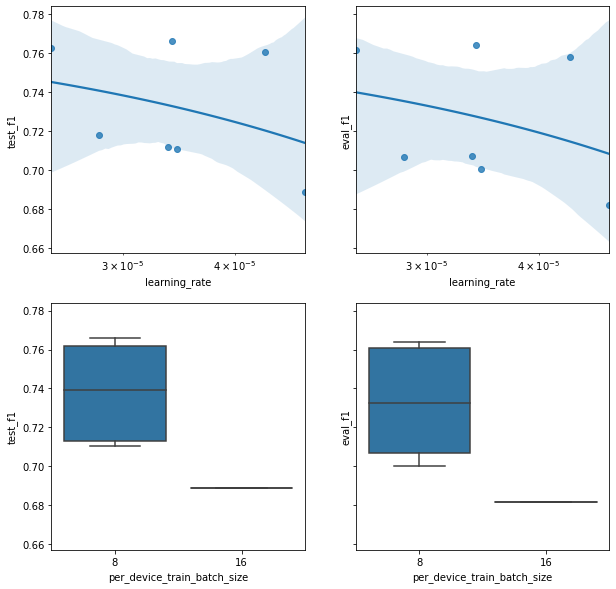

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

save_path = f'./run/hyperparameter_tuning/ASHA_{code}'

fig, ax = plt.subplots(2,2, figsize=(10,10),sharey=True)

sns.regplot(data=results_df, x='learning_rate', y='test_f1',ax=ax[0][0])
sns.regplot(data=results_df, x='learning_rate', y='eval_f1',ax=ax[0][1])
ax[0][0].set(xscale="log")
ax[0][1].set(xscale="log")

sns.boxplot(data=results_df, ax=ax[1][0], x='per_device_train_batch_size',y='test_f1')
sns.boxplot(data=results_df, ax=ax[1][1], x='per_device_train_batch_size',y='eval_f1')

results_df.to_csv(save_path + '.csv')
plt.savefig(save_path + '.png')